# 量化策略回测框架

## 核心逻辑:
1.  **迭代式状态机**: 程序通过循环模拟时间流逝，并维护一个“活跃持仓”列表 (`active_trades`)，精确追踪每一个未平仓的头寸。
2.  **信号对冲优先**:
    - 当 `T-1` 时刻产生一个新信号时，程序在 `T` 时刻会首先检查 `active_trades` 中是否存在方向相反的持仓。
    - **如果找到**: 则将该持仓与新信号“对冲”。这被视为一笔完整的交易，在 `T` 时刻平仓。这笔交易的 PnL 被立即计算并记录。新信号被消耗，不再开立新仓。
    - **如果未找到**: 则新信号会在 `T` 时刻正常开立一笔新仓，并将其加入到 `active_trades` 列表中，同时设定一个 `holding_period` 后的到期时间。
3.  **到期处理**: 在每个时间点，程序也会检查 `active_trades` 中是否有持仓达到 `holding_period` 而自然到期的。如果有，则将其平仓并计算 PnL。
4.  **精确的成本与收益核算**:
    - **PnL实现**: 任何交易（无论是对冲平仓还是到期平仓）的盈亏都在其平仓的那个时间点被计算和记录。
    - **手续费**: 每一笔完成的、独立的交易（从开仓到平仓）都会被收取一次完整的往返手续费 (`2 * commission_rate`)。
5.  **单利计算**: 所有已实现交易的盈亏以单利模式进行累加，生成最终的权益曲线。
6.  **相关性检验**: 将本策略的最终收益与一个简化的“信号*10周期远期收益”理论基准进行比较，以评估对冲逻辑带来的影响。

In [6]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from tabulate import tabulate
from colorama import Fore, Style
import pickle
from pathlib import Path

---
## 1. 日志和绘图设置

In [7]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

---
## 2. 核心回测与评估函数

In [8]:
def run_backtest_with_merging_logic(prices, signals, initial_capital=100000, commission_rate=0.0002, holding_period=10):
    """
    基于迭代和信号合并/对冲逻辑的回测。
    """
    logging.info(f"🤔 开始执行修正版回测 (迭代式信号对冲, 持仓周期: {holding_period})...")

    # --- 数据结构初始化 ---
    active_trades = []  # 列表，存储活跃交易的字典: {'entry_time', 'direction', 'entry_price'}
    completed_trades = [] # 列表，存储已完成交易的字典

    # 信号在T-1产生，在T生效
    trade_triggers = signals.shift(1).fillna(0)

    # --- 时间驱动的事件循环 ---
    for i in range(len(prices)):
        current_time = prices.index[i]
        current_price = prices.iloc[i]

        # --- 1. 处理到期平仓 ---
        # 使用列表推导式来筛选出未到期的交易，避免在循环中修改列表
        trades_to_keep = []
        for trade in active_trades:
            entry_time_loc = prices.index.get_loc(trade['entry_time'])
            # 使用 bar 的数量来判断是否到期，更稳健
            if i >= entry_time_loc + holding_period:
                # 此交易已到期，进行平仓结算
                net_return = trade['direction'] * (current_price / trade['entry_price'] - 1) - (2 * commission_rate)
                completed_trades.append({
                    'entry_time': trade['entry_time'],
                    'exit_time': current_time,
                    'direction': trade['direction'],
                    'net_return': net_return,
                    'type': 'Expired' # 标记为到期平仓
                })
            else:
                trades_to_keep.append(trade)
        active_trades = trades_to_keep

        # --- 2. 处理新信号 ---
        new_signal = trade_triggers.iloc[i]
        if new_signal != 0:
            # --- 2a. 尝试对冲/合并 ---
            offset_found = False
            # 寻找一个方向相反的、最早的活跃交易进行对冲
            # 我们从 active_trades 列表中寻找
            trade_to_offset_index = -1
            for j, trade in enumerate(active_trades):
                if trade['direction'] == -new_signal:
                    trade_to_offset_index = j
                    break # 找到第一个就停止

            if trade_to_offset_index != -1:
                # 找到了可以对冲的交易
                trade_to_close = active_trades.pop(trade_to_offset_index)
                
                # 结算这笔被对冲的交易
                net_return = trade_to_close['direction'] * (current_price / trade_to_close['entry_price'] - 1) - (2 * commission_rate)
                completed_trades.append({
                    'entry_time': trade_to_close['entry_time'],
                    'exit_time': current_time,
                    'direction': trade_to_close['direction'],
                    'net_return': net_return,
                    'type': 'Merged/Offset' # 标记为对冲平仓
                })
                offset_found = True

            # --- 2b. 如果没有发生对冲，则开新仓 ---
            if not offset_found:
                active_trades.append({
                    'entry_time': current_time,
                    'direction': new_signal,
                    'entry_price': current_price
                })

    # --- 3. 回测结束，强制平掉所有剩余的活跃仓位 ---
    final_time = prices.index[-1]
    final_price = prices.iloc[-1]
    for trade in active_trades:
        net_return = trade['direction'] * (final_price / trade['entry_price'] - 1) - (2 * commission_rate)
        completed_trades.append({
            'entry_time': trade['entry_time'],
            'exit_time': final_time,
            'direction': trade['direction'],
            'net_return': net_return,
            'type': 'End of Backtest'
        })

    logging.info(f"回测完成。共结算 {len(completed_trades)} 笔交易。")
    if not completed_trades:
        logging.warning("未能生成任何交易。")
        return pd.DataFrame(), pd.DataFrame()

    # --- 4. 构建结果 ---
    trades_df = pd.DataFrame(completed_trades)
    
    # 计算每日实现的净收益流
    pnl_by_exit_time = trades_df.groupby('exit_time')['net_return'].sum()
    daily_net_returns = pnl_by_exit_time.reindex(prices.index).fillna(0)
    
    # 计算累计收益率 (单利)
    cumulative_returns_simple = daily_net_returns.cumsum()

    # 整合最终结果
    backtest_results = pd.DataFrame(index=prices.index)
    backtest_results['close'] = prices
    backtest_results['signal'] = signals
    backtest_results['strategy_net_returns'] = daily_net_returns
    backtest_results['equity_curve_simple_return'] = cumulative_returns_simple
    
    return backtest_results, trades_df

In [9]:
def evaluate_performance_corrected(backtest_results, trades_df, initial_capital):
    """
    评估策略表现
    """
    logging.info("🤔🤔🤔 开始评估策略表现 (修正版)...")

    if backtest_results.empty or trades_df.empty:
        logging.error("回测结果为空，无法进行评估。")
        return

    # --- 数据提取 ---
    net_returns = backtest_results['strategy_net_returns']
    equity_curve_returns = backtest_results['equity_curve_simple_return']
    
    equity_curve_value = initial_capital * (1 + equity_curve_returns)
    
    market_returns = backtest_results['close'].pct_change().fillna(0)
    benchmark_equity = initial_capital * (1 + market_returns).cumprod()

    # --- 交易统计 ---
    total_trades = len(trades_df)
    winning_trades = trades_df[trades_df['net_return'] > 0]
    losing_trades = trades_df[trades_df['net_return'] <= 0]
    num_winning_trades = len(winning_trades)

    # --- 核心指标计算 (适配单利) ---
    total_days = (equity_curve_returns.index[-1] - equity_curve_returns.index[0]).days
    duration_years = total_days / 365.25 if total_days > 0 else 1

    total_return = equity_curve_returns.iloc[-1]
    annualized_return = total_return / duration_years if duration_years > 0 else 0

    monthly_net_returns = net_returns.resample('M').sum()
    annualized_volatility = monthly_net_returns.std() * np.sqrt(12) if not monthly_net_returns.empty and monthly_net_returns.std() != 0 else 0

    running_max_return = equity_curve_returns.cummax()
    drawdown_return = running_max_return - equity_curve_returns
    max_drawdown_return = drawdown_return.max()
    peak_return_at_mdd_start = running_max_return.loc[drawdown_return.idxmax()] if not drawdown_return.empty else 0
    peak_capital_at_mdd_start = initial_capital * (1 + peak_return_at_mdd_start)
    max_drawdown_pct = (max_drawdown_return * initial_capital) / peak_capital_at_mdd_start if peak_capital_at_mdd_start > 0 else 0

    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility > 0 else 0
    calmar_ratio = annualized_return / max_drawdown_pct if max_drawdown_pct != 0 else 0

    win_rate = num_winning_trades / total_trades if total_trades > 0 else 0
    total_profit = winning_trades['net_return'].sum()
    total_loss = abs(losing_trades['net_return'].sum())
    profit_loss_ratio = total_profit / total_loss if total_loss > 0 else np.inf
    
    avg_win = winning_trades['net_return'].mean() if num_winning_trades > 0 else 0
    avg_loss = abs(losing_trades['net_return'].mean()) if len(losing_trades) > 0 else 0
    expectancy = (win_rate * avg_win) - ((1 - win_rate) * avg_loss) if total_trades > 0 else 0

    # --- 打印报告 ---
    print("\n" + "="*80)
    print(Fore.CYAN + Style.BRIGHT + " " * 20 + "策略性能评估报告 (程序2-修正版)" + " " * 20 + Style.RESET_ALL)
    print("="*80)
    
    detail_headers = ["指标名称", "值"]
    detail_table = [
        ["回测模型", "迭代式信号对冲"],
        ["总收益率 (Total Return)", f"{total_return:.2%}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.2%}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.2%}"],
        ["夏普比率 (Sharpe Ratio)", f"{sharpe_ratio:.4f}"],
        ["最大回撤 (Max Drawdown)", f"{max_drawdown_pct:.2%}"],
        ["卡玛比率 (Calmar Ratio)", f"{calmar_ratio:.4f}"],
        ["总交易笔数", f"{total_trades}"],
        ["胜率 (Win Rate)", f"{win_rate:.2%}"],
        ["盈亏比 (Profit/Loss Ratio)", f"{profit_loss_ratio:.4f}"],
        ["期望收益 (Expectancy)", f"{expectancy:.6f}"],
        ["最终资金 (Final Capital)", f"${equity_curve_value.iloc[-1]:,.2f}"]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))

    # --- 新增：交易类型分析 ---
    print("\n" + Fore.CYAN + Style.BRIGHT + "--- 交易类型分析 ---" + Style.RESET_ALL)
    trade_type_counts = trades_df['type'].value_counts().reset_index()
    trade_type_counts.columns = ['平仓类型', '数量']
    trade_type_counts['占比'] = (trade_type_counts['数量'] / total_trades * 100).apply(lambda x: f"{x:.2f}%")
    print(tabulate(trade_type_counts, headers="keys", tablefmt="grid", stralign="center", showindex=False))

    # --- 绘制权益曲线图 ---
    fig, ax = plt.subplots(figsize=(20, 10))
    equity_curve_value.plot(label='Strategy Equity (Corrected Merging Logic)', lw=2, color='royalblue', ax=ax)
    benchmark_equity.plot(label='Buy & Hold Benchmark', lw=2, linestyle='--', color='darkorange', ax=ax)
    ax.set_title('Corrected Strategy Equity Curve vs. Benchmark', fontsize=16)
    ax.set_ylabel('Equity Value ($)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    logging.info("🎊🎊🎊 策略评估完成 🎊🎊🎊")

---
## 3. 主程序执行

2025-07-24 16:16:22,132 - INFO - 正在从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-24 16:16:22,140 - INFO - 数据加载成功。
2025-07-24 16:16:22,141 - INFO - 🤔 开始执行修正版回测 (迭代式信号对冲, 持仓周期: 10)...
2025-07-24 16:16:24,679 - INFO - 回测完成。共结算 25526 笔交易。
2025-07-24 16:16:24,712 - INFO - 已完成交易详情 (前5笔):
2025-07-24 16:16:24,718 - INFO - 🤔🤔🤔 开始评估策略表现 (修正版)...


           entry_time           exit_time  direction  net_return     type
0 2021-09-27 06:30:00 2021-09-27 09:00:00        1.0   -0.001956  Expired
1 2021-09-27 06:45:00 2021-09-27 09:15:00        1.0    0.005625  Expired
2 2021-09-27 07:00:00 2021-09-27 09:30:00        1.0   -0.004493  Expired
3 2021-09-27 07:15:00 2021-09-27 09:45:00        1.0   -0.005014  Expired
4 2021-09-27 07:45:00 2021-09-27 10:15:00        1.0    0.002947  Expired

                         与理论基准的相关性检验                         
策略累计净收益 与 'signal * 10-period_forward_return' 的累计毛收益 的相关系数为: 0.99916645
✅ 策略与理论基准高度相关：整体趋势一致。


                    策略性能评估报告 (程序2-修正版)                    
+--------------------------------+----------------+
|            指标名称            |       值       |
+================================+================+
|            回测模型            | 迭代式信号对冲 |
+--------------------------------+----------------+
|    总收益率 (Total Return)     |    478.89%     |
+--------------------------------+------------

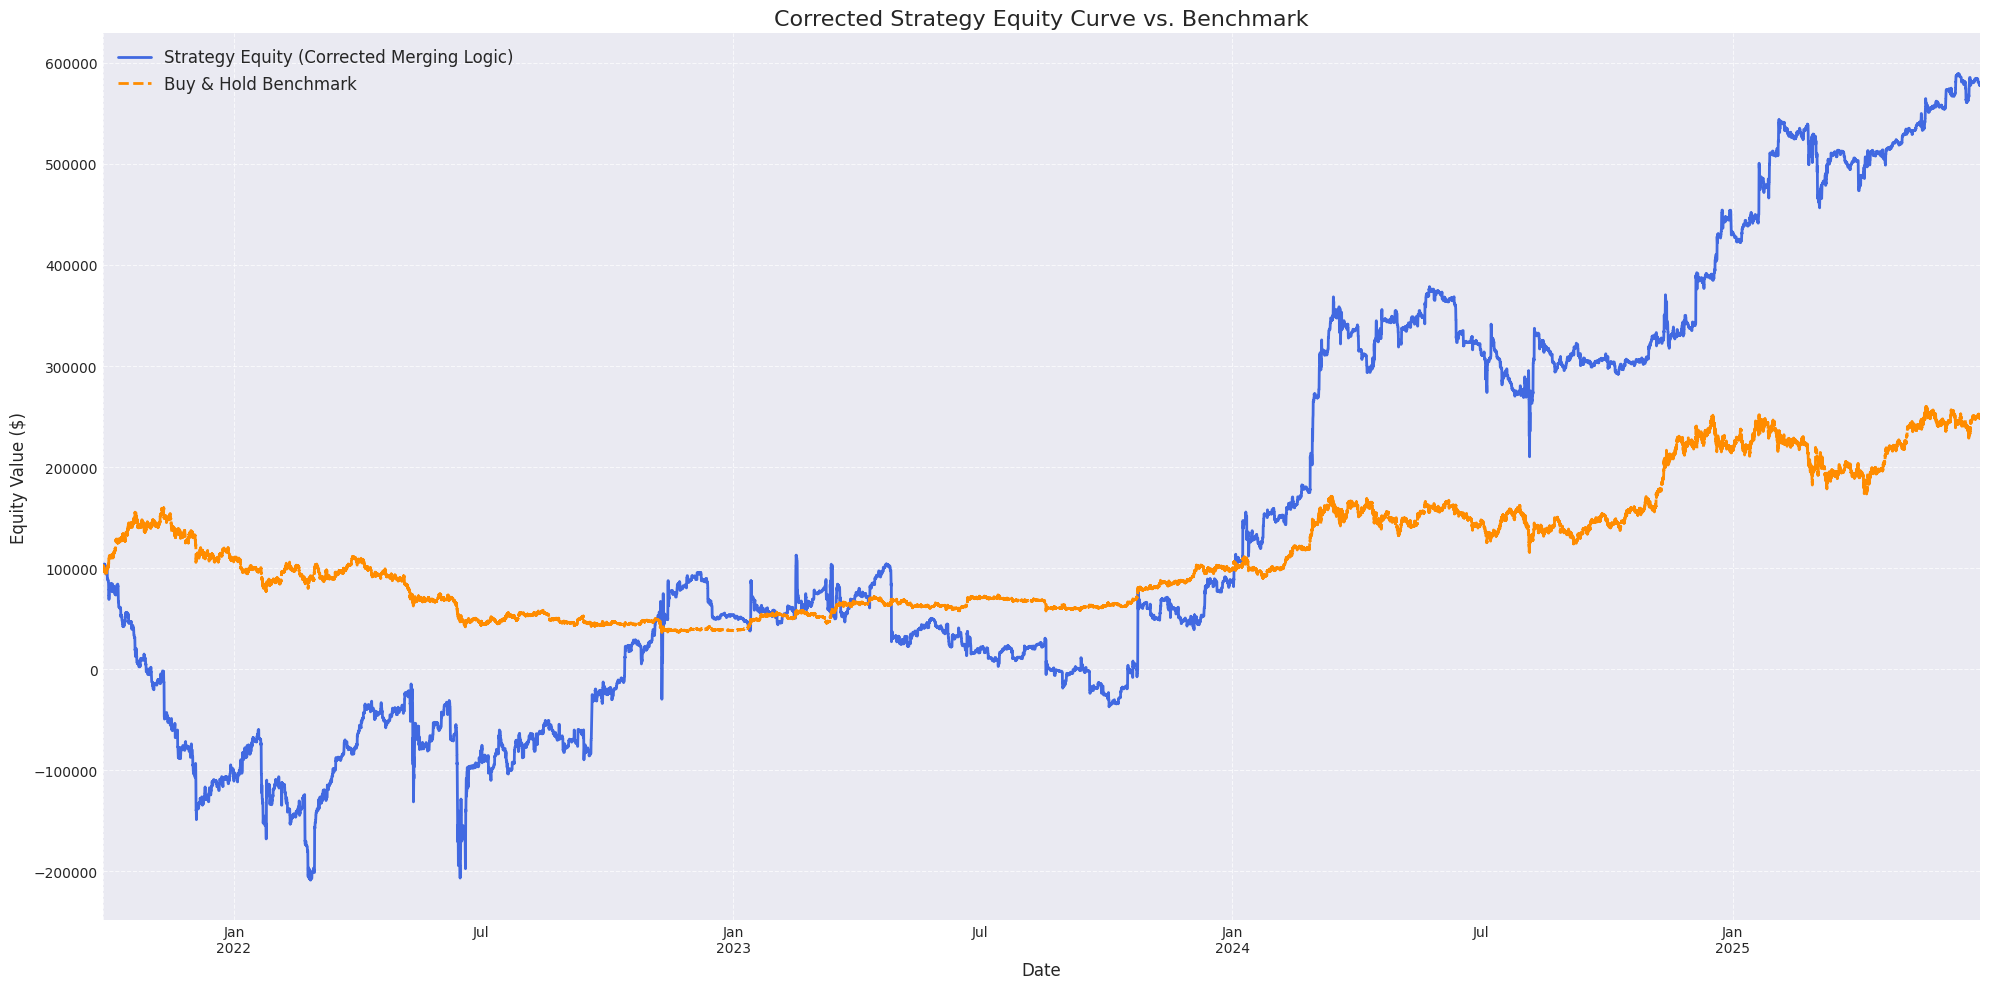

2025-07-24 16:16:27,496 - INFO - 🎊🎊🎊 策略评估完成 🎊🎊🎊


In [ ]:
if __name__ == '__main__':
    # --- 1. 参数配置 ---
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    COMMISSION_RATE = 0.0002
    INITIAL_CAPITAL = 100000
    HOLDING_PERIOD = 10
    
    # --- 2. 数据加载 ---
    logging.info(f"正在从 {FILE_PATH} 加载数据...")
    try:
        file_path = Path(FILE_PATH)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        data.index = pd.to_datetime(data.index)
        data = data.rename_axis('open_time')
        logging.info("数据加载成功。")
    except Exception as e:
        logging.error(f"加载数据时发生错误: {e}")
        data = None

    # --- 3. 执行回测 (使用修正后的函数) ---
    if data is not None:
        backtest_results, trades_df = run_backtest_with_merging_logic(
            prices=data['close'],
            signals=data['signal'],
            initial_capital=INITIAL_CAPITAL,
            commission_rate=COMMISSION_RATE,
            holding_period=HOLDING_PERIOD
        )
        
        logging.info("已完成交易详情 (前5笔):")
        print(trades_df.head())

        # --- 4. 【新增】与理论基准的相关性检验 ---
        print("\n" + "="*80)
        print(Fore.YELLOW + Style.BRIGHT + " " * 25 + "与理论基准的相关性检验" + " " * 25 + Style.RESET_ALL)
        print("="*80)

        # 1. 计算理论基准收益 (每个信号都持有10个周期，不发生对冲，不计手续费)
        #    这是一个简化的理论模型，用于对比
        theoretical_forward_returns = (data['close'].shift(-HOLDING_PERIOD) / data['close']) - 1
        theoretical_per_trade_returns = data['signal'].shift(1) * theoretical_forward_returns
        theoretical_cumulative_returns = theoretical_per_trade_returns.cumsum().fillna(0)

        # 2. 获取策略的累计净收益
        strategy_cumulative_returns = backtest_results['equity_curve_simple_return']

        # 3. 计算相关性 (pandas会自动对齐索引)
        correlation = strategy_cumulative_returns.corr(theoretical_cumulative_returns)

        print(f"策略累计净收益 与 'signal * 10-period_forward_return' 的累计毛收益 的相关系数为: {Fore.CYAN}{correlation:.8f}{Style.RESET_ALL}")
        
        if correlation > 0.8:
            print(Fore.GREEN + "✅ 策略与理论基准高度相关：整体趋势一致。" + Style.RESET_ALL)
        else:
            print(Fore.YELLOW + "⚠️ 策略与理论基准相关性不高：显著改变了策略。" + Style.RESET_ALL)
        print("="*80 + "\n")

        # --- 5. 性能评估 ---
        evaluate_performance_corrected(
            backtest_results, 
            trades_df,
            INITIAL_CAPITAL
        )
    else:
        logging.warning("由于数据加载失败，回测和评估步骤已跳过。")